# Analiza clusterilor ierarhici

Schimbând perspectiva de la studiul variabilelor la gruparea **obiectelor (mașinilor)**, vom identifica familii naturale de vehicule bazate pe similarități tehnice, fără a cunoaște a priori segmentul din care fac parte.
Dendrograma rezultată va vizualiza distanțele dintre modele, permițând decizia obiectivă asupra numărului optim de clase (clusteri) existente în piața auto din 2023.

In [2]:
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as hclust
from scipy.cluster.hierarchy import fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score,silhouette_samples
from utils import *

masini=pd.read_csv('SET DE DATE/Specificatii masini 2023.csv',index_col=(0,1))
replaceNan(masini)
variabile=masini.columns[2:].tolist()
observatii=masini.index.tolist()

n=len(observatii)   #marimea esantionului
p=n-1 #cati clusteri putem avea

masini.head()

Segment      Fuel  \
Company    Model                                                       
ALFA ROMEO ALFA ROMEO Giulia (2022-Present)        Compact  Gasoline   
           ALFA ROMEO Giulia (2022-Present)        Compact    Diesel   
           2023 Alfa Romeo Stelvio              Medium SUV  Gasoline   
           2023 Alfa Romeo Stelvio              Medium SUV    Diesel   
           ALFA ROMEO Giulietta (2016-Present)     Compact  Gasoline   

                                                Power(HP)  Torque(Nm)  \
Company    Model                                                        
ALFA ROMEO ALFA ROMEO Giulia (2022-Present)         280.0       400.0   
           ALFA ROMEO Giulia (2022-Present)         210.0       470.0   
           2023 Alfa Romeo Stelvio                  280.0       400.0   
           2023 Alfa Romeo Stelvio                  210.0       470.0   
           ALFA ROMEO Giulietta (2016-Present)      120.0       215.0   

                                                Displacement  Length  Width  \
Company    Model                                                              
ALFA ROMEO ALFA ROMEO Giulia (2022-Present)           1995.0   183.1   73.2   
           ALFA ROMEO Giulia (2022-Present)           2143.0   183.1   73.2   
           2023 Alfa Romeo Stelvio                    1995.0   184.5   74.9   
           2023 Alfa Romeo Stelvio                    2143.0   184.5   74.9   
           ALFA ROMEO Giulietta (2016-Present)        1368.0   171.3   70.8   

                                                Height  Wheelbase  \
Company    Model                                                    
ALFA ROMEO ALFA ROMEO Giulia (2022-Present)       56.6      111.0   
           ALFA ROMEO Giulia (2022-Present)       56.6      111.0   
           2023 Alfa Romeo Stelvio                66.7      110.9   
           2023 Alfa Romeo Stelvio                66.7      110.9   
           ALFA ROMEO Giulietta (2016-Present)    57.7      103.7   

                                                Cargo Volume  Unladen Weight  \
Company    Model                                                               
ALFA ROMEO ALFA ROMEO Giulia (2022-Present)             17.0          3406.0   
           ALFA ROMEO Giulia (2022-Present)             17.0          3450.0   
           2023 Alfa Romeo Stelvio                      18.5          3704.0   
           2023 Alfa Romeo Stelvio                      18.5          3847.0   
           ALFA ROMEO Giulietta (2016-Present)          12.4          2987.0   

                                                Top Speed  \
Company    Model                                            
ALFA ROMEO ALFA ROMEO Giulia (2022-Present)         149.0   
           ALFA ROMEO Giulia (2022-Present)         146.0   
           2023 Alfa Romeo Stelvio                  143.0   
           2023 Alfa Romeo Stelvio                  134.0   
           ALFA ROMEO Giulietta (2016-Present)      121.0   

                                                Acceleration 0-62 Mph (0-100 kph)  \
Company    Model                                                                    
ALFA ROMEO ALFA ROMEO Giulia (2022-Present)                                   5.2   
           ALFA ROMEO Giulia (2022-Present)                                   6.8   
           2023 Alfa Romeo Stelvio                                            5.7   
           2023 Alfa Romeo Stelvio                                            6.6   
           ALFA ROMEO Giulietta (2016-Present)                                9.4   

                                                Combined mpg  Fuel capacity  
Company    Model                                                             
ALFA ROMEO ALFA ROMEO Giulia (2022-Present)             30.5           15.3  
           ALFA ROMEO Giulia (2022-Present)             42.8           15.3  
           2023 Alfa Romeo Stelvio                      28.0           16.9  
           2023 Alfa 

## Crearea modelului de clusteri ierarhici

Reprezintă structura matematică a dendrogramei, stocând ordinea în care mașinile sunt unite în clusteri. Fiecare rând descrie o etapă de unire: care două entități (sau sub-clusteri) sunt comasate și la ce distanță.

Metoda *Ward* utilizată aici minimizează variația în interiorul clusterilor la fiecare pas, formând grupuri cât mai compacte și omogene din punct de vedere statistic.

In [3]:
x_orig=masini[variabile].values
x=StandardScaler().fit_transform(x_orig)

h=hclust.linkage(x,method='ward')
print(h)

[[1.68900000e+03 1.69000000e+03 0.00000000e+00 2.00000000e+00]
 [1.07100000e+03 1.07200000e+03 0.00000000e+00 2.00000000e+00]
 [1.41700000e+03 1.42100000e+03 0.00000000e+00 2.00000000e+00]
 ...
 [3.37600000e+03 3.37800000e+03 4.58582035e+01 3.02000000e+02]
 [3.37700000e+03 3.38100000e+03 7.33365529e+01 1.39100000e+03]
 [3.38200000e+03 3.38300000e+03 1.12993354e+02 1.69300000e+03]]


## Cautăm numărul optim de clusteri

Pentru a evita alegerea directă a numărului de clusteri, calculăm diferențele dintre distanțele de agregare succesive. Punctul în care apare cel mai mare "salt" (diferență maximă) indică pragul natural de separare.
*   Acesta este momentul în care unirea a doi clusteri ar forța împreună grupuri prea diferite, crescând brusc heterogenitatea.
*   Codul identifică acest punct (`k_max`) și sugerează numărul ideal de clase (în acest caz, **2 clusteri**).

In [5]:
k_max=np.argmax(h[1:,2]-h[:-1,2])
nr_clusteri=p-k_max
print(f"Numarul optim de clusteri este: {nr_clusteri}")
#creare partitie automata cu fcluster
auto=fcluster(h,nr_clusteri,criterion='maxclust')

Numarul optim de clusteri este: 2


## Indecși Sillhouette
Măsoară calitatea segmentării pentru fiecare mașină în parte, cuantificând cât de bine se potrivește un obiect în clusterul său comparativ cu celelalte.
Valoarea variază între -1 și 1:
*   **Valori spre 1:** Mașina este "tipică" pentru clusterul său și foarte diferită de restul (0.5+ indică o structură clară).
*   **Valori spre 0:** Mașina este la granița dintre două categorii, având caracteristici hibride (nu este decisiv plasată).
*   **Media scorurilor:** Indică validitatea globală a partiției (cu cât mai mare, cu atât segmentarea este mai robustă).

In [9]:
sill_instance=silhouette_samples(x,auto)  #ptr fiecare masina in parte
sill_partitie=silhouette_score(x,auto)  #media pe partitie
print(f"Media pe partitie este {np.round(sill_partitie,3)}")
sDf=toDataFrame(sill_instance.reshape(-1,1),masini.index,['Silhouette'],'Silhouette.csv')
sDf.head(10)

Media pe partitie este 0.392


Silhouette
Company    Model                                          
ALFA ROMEO ALFA ROMEO Giulia (2022-Present)       0.197069
           ALFA ROMEO Giulia (2022-Present)       0.297361
           2023 Alfa Romeo Stelvio                0.124570
           2023 Alfa Romeo Stelvio                0.197475
           ALFA ROMEO Giulietta (2016-Present)    0.566032
           ALFA ROMEO Giulietta (2016-Present)    0.532174
           ALFA ROMEO Giulietta (2016-Present)    0.548619
           ALFA ROMEO Giulietta (2016-Present)    0.553777
           ALFA ROMEO Giulietta (2016-Present)    0.553123
           ALFA ROMEO Giulietta (2016-Present)    0.494281

## Identificarea Pragului Critic

Acest pas localizează exact punctul din procesul de agregare unde apare cea mai mare discontinuitate în distanțe (în cazul nostru, la pasul 1691).

Valoarea de *73.33* reprezintă distanța maximă acceptabilă pentru unirea clusterilor. Orice unire peste acest prag ar forța împreună grupuri prea distincte, scăzând calitatea partiției. Această valoare ne servește drept linie de "tăiere" pentru dendrogramă.

In [10]:
distante=h[:,2]
diferente=np.diff(distante)
pas_maxim=np.argmax(diferente)
valoare_max=distante[pas_maxim]
print(f"Jonctiunea (Pasul) cu valoarea maxima este {pas_maxim+1}")
print(f"Valoarea pragului de la jonctiunea maxima este: {valoare_max}")

Jonctiunea (Pasul) cu valoarea maxima este 1691
Valoarea pragului de la jonctiunea maxima este: 73.33655291968287


## Grafice

### Crearea funcției de desenare histogramă

Această funcție construiește grafice comparative pentru o variabilă aleasă (*variabila*), afișând câte o histogramă pentru fiecare cluster în parte.

Rolul ei este de a evidenția diferențele de distribuție dintre grupuri (de exemplu, dacă un cluster conține doar mașini cu *Power* mare, iar altul doar cu *Power* mic).

In [11]:
def histograma(x,variabila,partitie):
    clustere_unice=np.unique(partitie)
    fig,axs=plt.subplots(1,len(clustere_unice),figsize=(10,6),sharey=True)
    fig.suptitle(f"Histograme ale variabilei {variabila}")
    for ax,cluster in zip(axs,clustere_unice):
        ax.hist(x[partitie==cluster],bins=15,rwidth=0.9)
        ax.set_title(cluster)

#### Desenare de histograme pentru primele 3 variabile

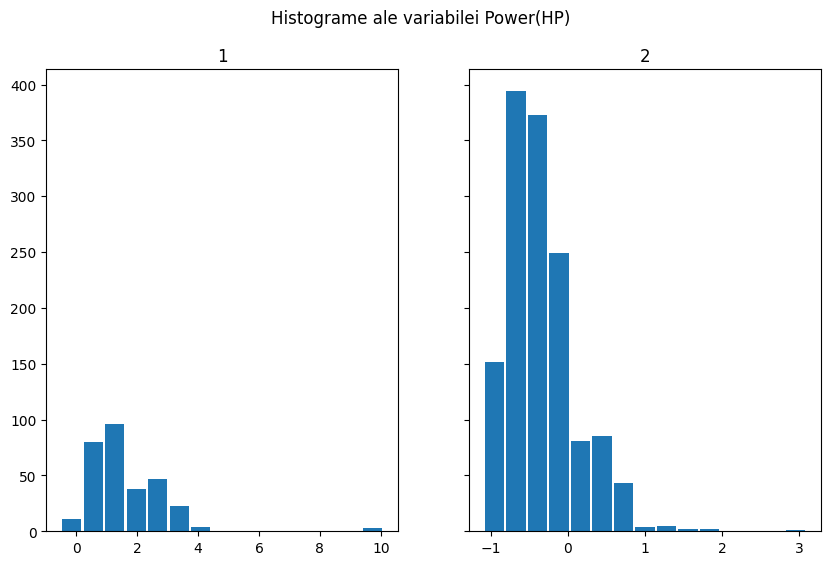

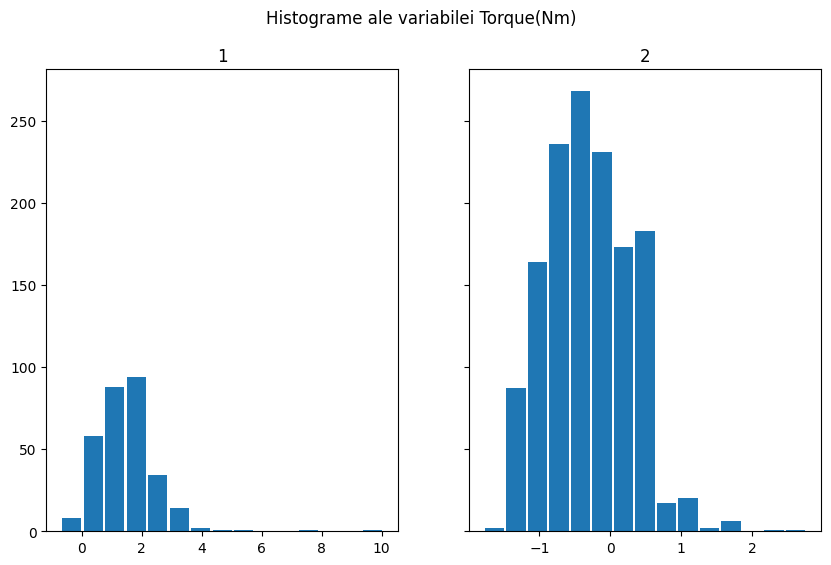

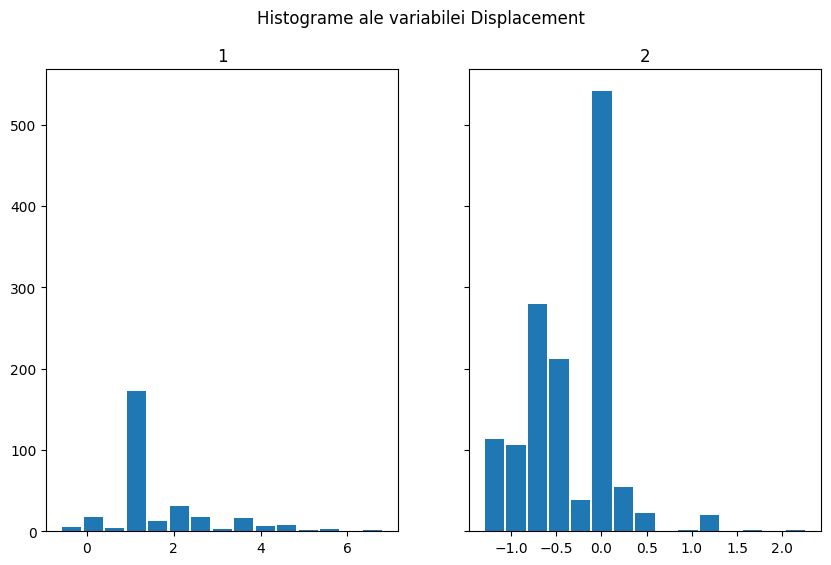

In [12]:
for i in range(3):
    histograma(x[:,i],variabile[i],auto)

Analizând distribuțiile pentru variabilele *Power*, *Torque* (Cuplu) și *Displacement* (Capacitate Cilindrică), observăm o diferențiere clară între cei doi clusteri principali afișați:
*   **Clusterul 1:** Prezintă o coadă lungă spre dreapta (valori pozitive mari). Acesta grupează **mașinile puternice, cu motoare mari** (supercar-uri sau SUV-uri de lux). Valorile sunt dispersate, indicând o varietate de motoare de top.
*   **Clusterul 2:** Distribuția este concentrată în jurul mediei (valori apropiate de 0 sau negative, după standardizare). Aici se află **mașinile obișnuite de serie**, cu motorizări standard, mult mai omogene.

### Dendrograma

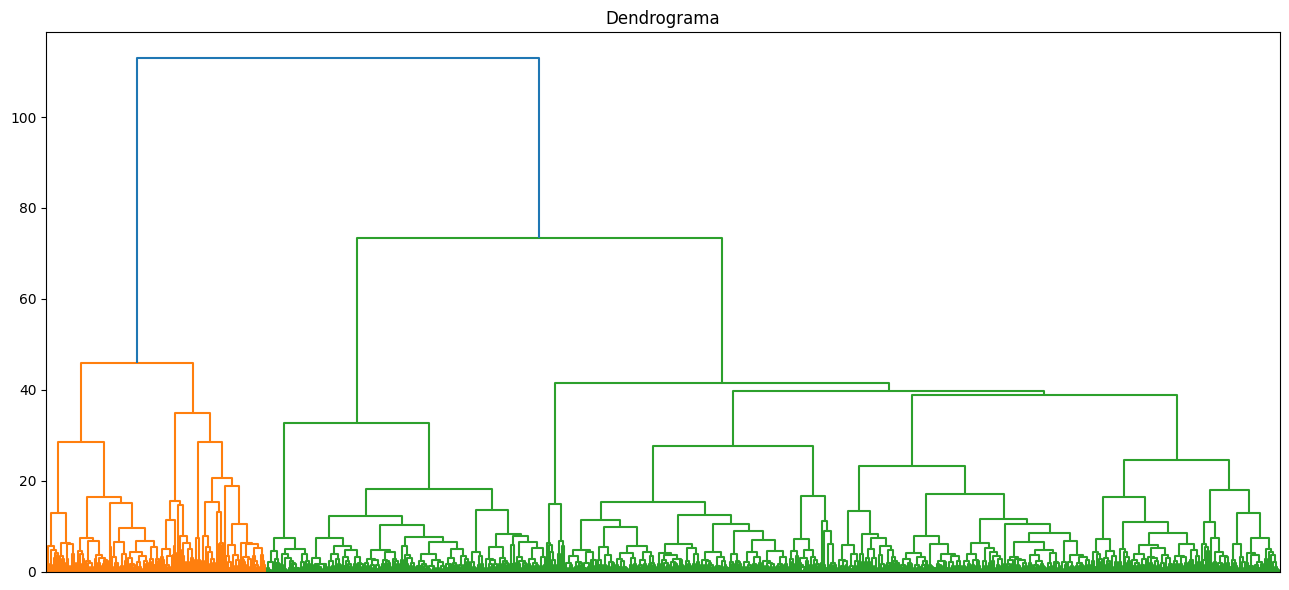

In [13]:
plt.figure(figsize=(13,6))
plt.title('Dendrograma')
hclust.dendrogram(h,
                  no_labels=True,
                  leaf_rotation=90,
                  leaf_font_size=8)
plt.tight_layout()
plt.show()

Graficul de sus în jos arată istoria completă a formării clusterilor:

La nivelul cel mai înalt, observăm o legătură masivă (linia albastră orizontală) care separă piața auto în două "lumi" distincte:
1.  **Ramura Portocalie (Stânga):** O grupare compactă și distinctă, care conține segmentul *Premium & Performance* (mașinile scumpe, puternice).
2.  **Ramura Verde (Dreapta):** O grupare mult mai vastă și ramificată, reprezentând *Mass Market* (mașinile standard, diverse).

Înălțimea legăturilor verticale indică gradul de disimilaritate: cu cât unirea se face mai sus, cu atât grupurile unite sunt mai diferite între ele. Tăierea dendrogramei la pragul optim calculat anterior (73.3) va secționa aceste ramuri principale în cei 2 clusteri specifici.